<a href="https://colab.research.google.com/github/ricospeloacaso/python_para_investimentos/blob/master/25_BackTesting_de_Carteira_com_Python_Parte_2_(BT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Documentação: https://pmorissette.github.io/bt/

###Python para Investimentos - BackTesting de Carteira com Python (BT)

**Python para Investimentos** é um conjunto de códigos e vídeos em que mostro como utilizar a linguagem de programação PYTHON através da ferramenta online Google Colab para fazer estudos no mercado financeiro.

**Canal no Youtube:** https://www.youtube.com/ricospeloacaso?sub_confirmation=1

Link para o Vídeo: https://youtu.be/B4UPZg0K6fI

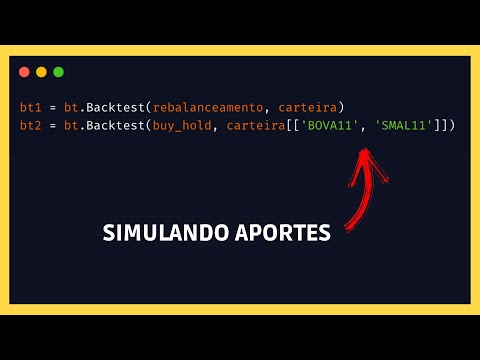

In [7]:
#@title Vídeo
from IPython.display import YouTubeVideo
YouTubeVideo('B4UPZg0K6fI', width=854, height=480)

## Biblioteca de Backtesting BT

Documentação: https://pmorissette.github.io/bt/

## Instalação e configurações Iniciais

In [10]:
!pip install bt

In [11]:
# Importa as bibliotecas
!pip install python-bcb

In [12]:
# Sistema Gerenciador de Séries Temporais do Banco Central
from bcb import sgs

In [13]:
#!pip install yfinance

In [14]:
import bt
import yfinance as yf

import pandas as pd
import matplotlib
matplotlib.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

##Funções

In [16]:
def consulta_bc(codigo_bcb, data_inicial, data_final):
  # Convertendo datas do formato ano-mês-dia para dia-mês-ano
  data_inicial_f = pd.to_datetime(data_inicial, format="%Y-%m-%d").strftime("%d/%m/%Y")
  data_final_f   = pd.to_datetime(data_final, format="%Y-%m-%d").strftime("%d/%m/%Y")
  url = 'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json&dataInicial={}&dataFinal={}'.format(codigo_bcb, data_inicial_f, data_final_f)
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)
  df.set_index('data', inplace=True)
  return df

In [17]:
def cdi_acumulado(data_inicio,data_fim):
  cdi = consulta_bc(12,data_inicio,data_fim)
  #cdi = sgs.get({'cdi':12}, start = '2016-01-01')
  cdi_acumulado = (1 + cdi[data_inicio : data_fim] / 100).cumprod()
  cdi_acumulado.iloc[0] = 1
  return cdi_acumulado

##Obtendo e tratando os dados

In [19]:
data_inicio = '2016-01-01'
data_fim    = '2025-05-31'

In [20]:
cdi = cdi_acumulado(data_inicio=data_inicio, data_fim=data_fim)

In [21]:
tickers_carteira = ['BOVA11.SA', 'SMAL11.SA']

In [22]:
carteira = yf.download(tickers_carteira, start=data_inicio, end=data_fim)['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


In [23]:
carteira['renda_fixa'] = cdi
carteira.dropna(inplace=True)

In [24]:
carteira.columns = carteira.columns.str.rstrip('.SA')

In [25]:
carteira

Ticker,BOVA11,SMAL11,renda_fixa
Date,,,
2016-01-04,41.099998,39.939999,1.000000
2016-01-05,41.180000,39.610001,1.001050
2016-01-06,40.500000,39.279999,1.001576
2016-01-07,39.470001,38.599998,1.002101
2016-01-08,39.340000,38.759998,1.002628
...,...,...,...
2025-05-22,134.050003,105.050003,2.241048
2025-05-23,134.470001,104.949997,2.242264
2025-05-26,135.009995,105.989998,2.243481


##Backtesting

In [27]:
rebalanceamento = bt.Strategy('rebalanceamento', 
                [bt.algos.RunMonthly(run_on_end_of_period=True),
                 bt.algos.SelectAll(),
                 bt.algos.CapitalFlow(10000),
                 bt.algos.WeighSpecified(BOVA11=0.4, SMAL11=0.4, renda_fixa=0.2),
                 bt.algos.Rebalance()])

In [28]:
buy_hold = bt.Strategy('Buy&Hold', 
                   [ bt.algos.RunOnce(),
                     bt.algos.SelectAll(),
                     bt.algos.WeighEqually(),
                     bt.algos.Rebalance()]
                    )

In [29]:
bt1 = bt.Backtest(rebalanceamento, carteira)
bt2 = bt.Backtest(buy_hold, carteira[['BOVA11', 'SMAL11']])

In [30]:
resultados = bt.run(bt1, bt2)

100%|██████████| 2/2 [00:00<00:00,  4.41it/s]


#Resultados

In [32]:
resultados.display()

Stat                 rebalanceamento    Buy&Hold
-------------------  -----------------  ----------
Start                2016-01-03         2016-01-03
End                  2025-05-28         2025-05-28
Risk-free rate       0.00%              0.00%

Total Return         199.90%            201.23%
Daily Sharpe         0.71               0.61
Daily Sortino        1.09               0.93
CAGR                 12.40%             12.45%
Max Drawdown         -40.08%            -49.27%
Calmar Ratio         0.31               0.25

MTD                  4.30%              4.89%
3m                   15.34%             17.83%
6m                   13.50%             14.79%
YTD                  17.82%             20.37%
1Y                   12.03%             11.82%
3Y (ann.)            6.08%              4.09%
5Y (ann.)            7.54%              6.47%
10Y (ann.)           12.40%             12.45%
Since Incep. (ann.)  12.40%             12.45%

Daily Sharpe         0.71               0.61
Daily 

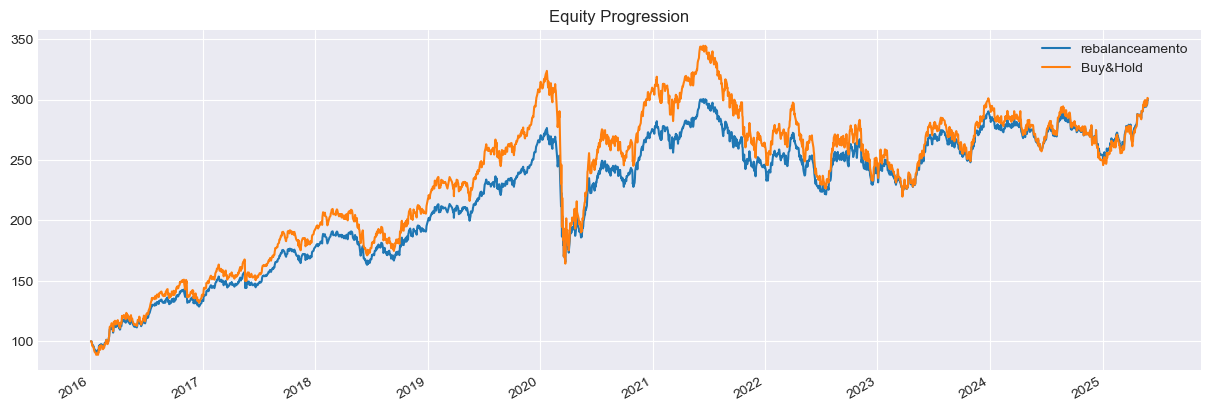

In [33]:
resultados.plot();

###Operações

In [35]:
resultados.get_transactions()

price  quantity
Date       Security                        
2016-01-04 BOVA11       41.099998    9829.0
           SMAL11       39.939999   10115.0
           renda_fixa    1.000000  202000.0
2016-01-29 BOVA11       39.189999     181.0
           SMAL11       37.709999     288.0
...                           ...       ...
2025-03-31 SMAL11       93.419998    -193.0
           renda_fixa    2.199812   16713.0
2025-04-30 BOVA11      131.630005     241.0
           SMAL11      101.500000    -566.0
           renda_fixa    2.223039   16100.0

[339 rows x 2 columns]

###Pesos

In [37]:
resultados.get_security_weights()

,BOVA11,SMAL11,renda_fixa
2016-01-03,0.000000,0.000000,0.000000
2016-01-04,0.399972,0.399993,0.200000
2016-01-05,0.401681,0.397609,0.200675
2016-01-06,0.398974,0.398215,0.202776
2016-01-07,0.395525,0.398062,0.206377
...,...,...,...
2025-05-22,0.398198,0.404693,0.197094
2025-05-23,0.399059,0.403917,0.197010
2025-05-26,0.398386,0.405602,0.195997
2025-05-27,0.397559,0.408810,0.193617


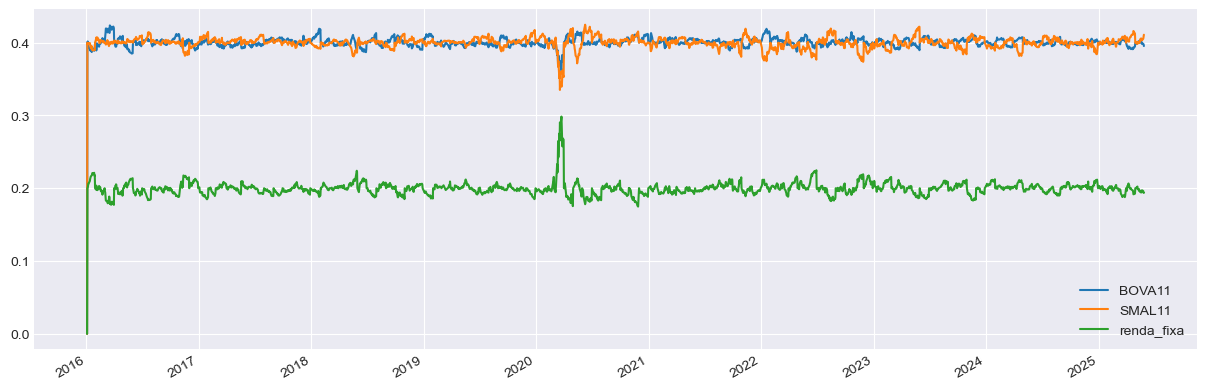

In [38]:
resultados.plot_security_weights()